<a href="https://colab.research.google.com/github/bmoretz/Notebooks/blob/master/Hands-OnMachineLearning/ch_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7

**`Ensemble Learning and Random Forests`**

# Setup

In [0]:
import numpy as np
import os

# stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

# Voting Classifiers

In [0]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

`Law of Large Numbers`

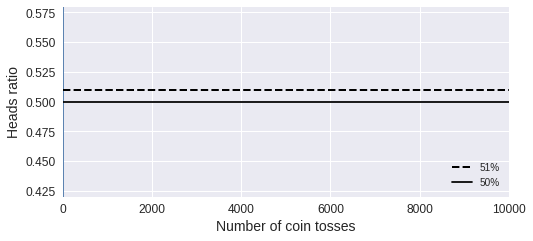

In [36]:
plt.figure(figsize=(8,3.5))

plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])

plt.show()

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [0]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

In [40]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [41]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

('LogisticRegression', 0.864)
('RandomForestClassifier', 0.872)
('SVC', 0.888)
('VotingClassifier', 0.896)


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [0]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)

In [43]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

('LogisticRegression', 0.864)
('RandomForestClassifier', 0.872)
('SVC', 0.888)
('VotingClassifier', 0.912)


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Bagging ensembles

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    max_samples = 100, bootstrap = True, n_jobs = -1
)

In [0]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [46]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.92


In [0]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

In [48]:
print(accuracy_score(y_test, y_pred_tree))

0.856


In [0]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

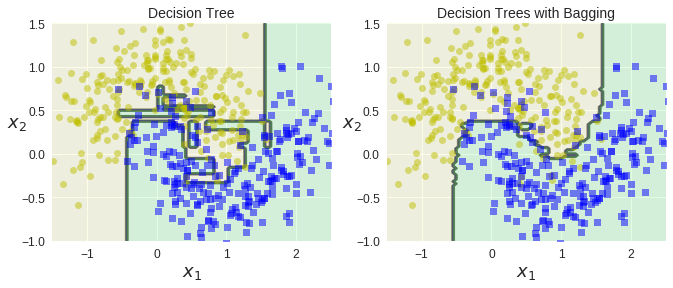

In [50]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)

plt.show()

# Random Forests

In [0]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes = 16, random_state = 42),
    n_estimators = 500, max_samples = 1.0, bootstrap = True, n_jobs = -1, random_state = 42
)

In [0]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [0]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [54]:
np.sum(y_pred == y_pred_rf) / len(y_pred)

0

In [55]:
from sklearn.datasets import load_iris

iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1, random_state = 42)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
  print(name, score)

('sepal length (cm)', 0.11249225099876374)
('sepal width (cm)', 0.023119288282510326)
('petal length (cm)', 0.44103046436395765)
('petal width (cm)', 0.4233579963547681)


In [56]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

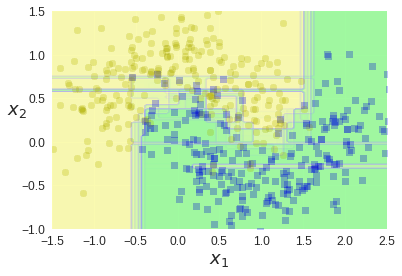

In [57]:
plt.figure(figsize=(6,4))

for i in range(15):
  tree_clf = DecisionTreeClassifier(max_leaf_nodes = 16, random_state = 42 + i)
  indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
  tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
  plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha = 0.02, contour = False)

# Out-of-Bag Evaluation

In [58]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap = True, n_jobs = -1, oob_score = True, random_state = 40
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [59]:
bag_clf.oob_decision_function_

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

In [60]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

# Feature Importance

In [0]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [65]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

NameError: ignored

In [0]:
def plot_digit(data):
  image = data.reshape(28, 28)
  plt.imshow(image, cmap = matplotlib.cm.hot,
            interpolation="nearest")
  plt.axis("off")

In [64]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

ValueError: ignored

# AdaBoost

In [4]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)

ada_clf.fit(X_train, y_train)

NameError: ignored

In [62]:
plot_decision_boundary(ada_clf, X, y)

NameError: ignored

In [0]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

plt.show()